In [1]:
import pennylane as qml
from pennylane import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import time

from matplotlib import pyplot as plt
%matplotlib inline

from tqdm import tqdm

import scipy
from scipy import optimize

In [2]:
from l2l import L2L

In [3]:
#declare devices for backend

shots = 100

# make sure you have quilc and qvm running
dev_default = qml.device('default.qubit', wires=2)
dev_numpy = qml.device('forest.numpy_wavefunction', wires=2)
dev_simulator = qml.device('forest.wavefunction', wires=2)
dev_pyqvm = qml.device('forest.qvm', device='2q-pyqvm', shots=shots)
dev_qvm = qml.device('forest.qvm', device='Aspen-4-2Q-A', shots=shots)

In [4]:
class L2LRot(L2L):
    def init_target(self):
        # pick a random number between 0 and 1 as the target expectation value
        self.target = (torch.rand(self.batch_size, self.rnn_input_size) - 0.5) * 2


def circ_function(dev):
    
    @qml.qnode(dev, interface='torch')
    def circuit(parameters):
        assert len(parameters) == 3

        phi = 2 * np.pi * parameters[:2]
        theta = 2 * np.pi * parameters[-1]
        qml.RX(phi[0], wires=0)
        qml.RZ(phi[1], wires=1)
        qml.CNOT(wires=[0, 1])
        qml.RX(theta, wires=0)
        return qml.expval(qml.PauliZ(0))

    return circuit

100%|██████████| 100/100 [10:04<00:00,  6.08s/it]


CPU times: user 15min 40s, sys: 4min 33s, total: 20min 14s
Wall time: 10min 4s


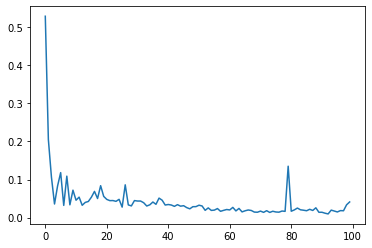

In [5]:
%%time 

l2l = L2LRot(circ_function(dev_default), 3, 16)

optimizer = optim.Adam(l2l.parameters(), lr=0.1)

num_epoch = 100
num_steps = 25 # 10

all_loss = []
for epoch_ind in tqdm(range(num_epoch)):

    l2l.zero_grad()
    l2l.init_hid_cell()
    l2l.init_target()

    for i in range(num_steps):
        l2l.step()

    loss = l2l.loss()
    loss.backward()
    optimizer.step()

    all_loss.append(loss.item())

plt.plot(all_loss)

In [6]:
#define class to call the different optimizers on a device

# neural optimizer
def neural_optimizer(target):
    l2l.batch_size = 1

    l2l.init_hid_cell()
    l2l.target = torch.tensor([[target]])

    for i in range(num_steps):
        l2l.step()

    return l2l.numpy_output()[1:]

# gradient descent
def gradient_descent(target, dev, lr=0.1):
    circuit = circ_function(dev)

    parameters = torch.rand(3, requires_grad=True)

    opt = torch.optim.Adam([parameters], lr=lr)

    output = []

    for i in range(num_steps):
        opt.zero_grad()
        result = circuit(parameters)
        loss = torch.abs(result - target) ** 2
        loss.backward()
        opt.step()

        output.append(result - target)

    return output

def neldermead(target, dev):

    circuit = circ_function(dev)
    
    def cost(parameters):
        result = circuit(parameters)
        return torch.abs(result - target) ** 2
    
    output = []
    def callback(x):
        fobj = circuit(x)
        output.append(fobj)
    
    initial_par = np.random.rand(3)
    opt_parameters = scipy.optimize.minimize(cost, initial_par, method='Nelder-Mead', callback=callback,
                                             options={'maxfev': num_steps, 'return_all': False})
    
    return output

In [10]:
def eval_plots(l2l, dev, target):
    l2l.function = circ_function(dev)

    fig, ax = plt.subplots(figsize = (12,7))
    start = time.time()
    ax.plot(neural_optimizer(target))
    stop = time.time()
    print('Neural optimizer took %.4f seconds.' %(stop-start))

    start = time.time()
    ax.plot(gradient_descent(target, dev))
    stop = time.time()
    print('Gradient descent took %.4f seconds.' %(stop-start))

    start = time.time()
    nelder_mead = neldermead(target, dev)
    ax.plot(np.array(nelder_mead)-target)
    stop = time.time()
    print('Nelder-Mead took %.4f seconds.' %(stop-start))

    ax.legend(['neural optimizer', 'gradient descent', 'nelder_mead'])
    ax.set_xlabel('steps'), ax.set_ylabel('error')
    ax.set_title('2 qubit rotation (device: %s)' %dev.short_name)

Neural optimizer took 0.0856 seconds.
Gradient descent took 0.4120 seconds.
Nelder-Mead took 0.0818 seconds.


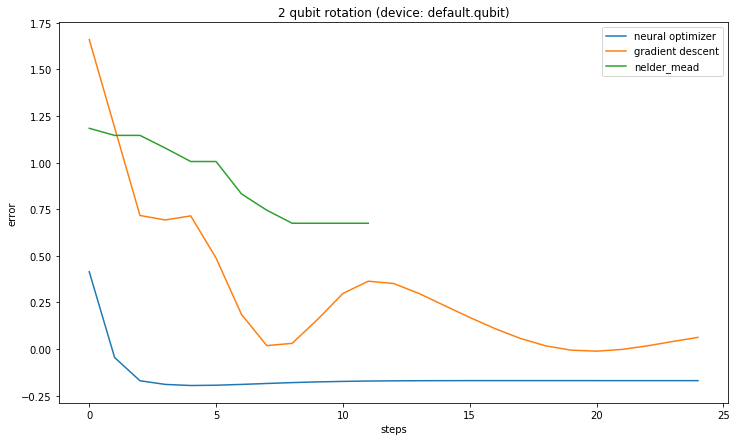

In [11]:
#set a target for the expectation value and evaluate on the default.qubit backend
target = -0.7
dev = dev_default

eval_plots(l2l, dev, target)

Neural optimizer took 1.2961 seconds.
Gradient descent took 8.4289 seconds.
Nelder-Mead took 1.9429 seconds.


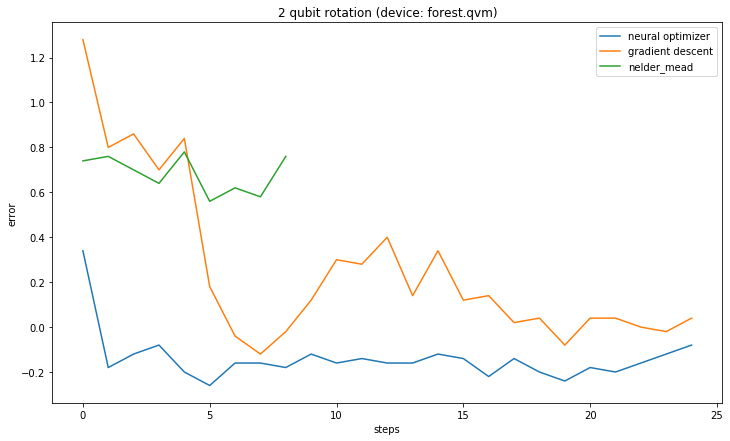

In [12]:
dev_default = qml.device('default.qubit', wires=2)
dev_numpy = qml.device('forest.numpy_wavefunction', wires=2)
dev_simulator = qml.device('forest.wavefunction', wires=2)

dev_pyqvm = qml.device('forest.qvm', device='2q-pyqvm', shots=shots)
dev_qvm = qml.device('forest.qvm', device='Aspen-4-2Q-A', shots=shots)
# dev_qpu = qml.device('forest.qpu', device='Aspen-4-2Q-A', shots=shots)

#set a target for the expectation value and evaluate on backend of your choice
target = -0.7
dev = dev_qvm

eval_plots(l2l, dev, target)